In [1]:
# Import all required libraries``
import pandas as pd
from summarytools import dfSummary


# Set pandas options
pd.set_option('future.no_silent_downcasting', True)

### Part I: Exploratory Data Analysis

This part of my work mainly focuses on understanding the underlying data and various relationships between different attributes


In [2]:
df = pd.read_csv('data/train_file.csv')
df.sample(n=5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
4661,46,blue-collar,married,basic.4y,unknown,unknown,unknown,telephone,may,thu,313,2,0,nonexistent,no
14168,53,technician,divorced,professional.course,no,no,no,telephone,may,fri,327,2,0,nonexistent,no
15355,76,retired,married,basic.4y,no,yes,no,cellular,sep,wed,259,2,1,success,yes
11347,24,student,single,unknown,no,yes,no,cellular,sep,wed,367,1,2,failure,no
5382,28,admin.,single,university.degree,no,yes,no,cellular,jul,wed,156,2,0,nonexistent,no


In [3]:
dfSummary(data=df, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 40.0 (10.4)min < med < max:17.0 < 38.0 < 98.0IQR (CV) : 15.0 (3.8),75 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAqJJREFUeJzt3T9v2kAYgPG72olciAzIEWxeGSJ1YPTSb5AP27VbBnYkvoE3JDAgKA7+V12kdmql2DHhXvP89jNW9MiynXtBV1WlANt9ufYJAO/hKotprb8qpe4bLj9XVXVq+ZRwJa7NkQZB8Oz7/qjJ+v1+n2itfxBrN1gbqrmSmkijKDoNBoO0zsLdbufN5/PRer02V2NC7QCbQ31jIh2Px78aLDW3DegI1+J7TL8sy7uWTwlCubbeY2ZZ5hVF8ZSm6YtSqskVFR3i2niPacRxPFoul708z53LnB4kcW29x0yShHtM/MULf4hAqBCBUCECoUIEQoUIhAoRCBUiECpEIFSIQKgQgVAhAqFCBEKFCIQKEawfRWmqKAozHeBrrZsegilWi3Qy1OPxeJdl2bcwDB3HcWpv2jaYYrVLJ0M9n8+u53m92WyWTiaTpO56pljt08lQ/+j3+00nWA0mDCzCwxREIFSIQKgQgVAhAqFCBEKFCIQKEQgVIhAqROj0f6auuKmFDS0tI9QLbGphQ0v7CLXlTS1saLkMQr3MphY2tLSMhymIQKgQgVAhAqFCBEKFCIQKEQgVIhAqRCBUiECoEIFQIQKhQgRChQiEChEIFSIQKkQgVIhAqBCBUNGNmSmttZn/MYNqdfllWZqR45vDqPUnh2oiDYLg2ff9Ud0DZ1nmFUXxlKbpi1Kq6bc+i8Oo9XWuqPcm0iiKToPBoNYfPY7j0XK57OV57qgbwqj1FcelTaR1x4aTJLnpkWFGrdvFwxREIFSIQKgQga/0sQw/jflvhNqxn8bcbrcHrfVPpVTapcjd9742qXvgw+HwtuZ4PHqr1ar3meulfvZms3kwr7am06keDoevDSJ9WCwW38MwfGwS+gcj/6jXqqr++7m/AfUtNx0LVAeCAAAAAElFTkSuQmCC"">",0(0.0%)
2,job[object],1. admin.2. blue-collar3. technician4. services5. management6. retired7. entrepreneur8. self-employed9. housemaid10. unemployed11. other,"8,305 (25.2%)7,430 (22.6%)5,392 (16.4%)3,192 (9.7%)2,343 (7.1%)1,364 (4.1%)1,159 (3.5%)1,098 (3.3%)855 (2.6%)798 (2.4%)974 (3.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA9RJREFUeJzt3TFuE0EAhtE1shA0jiJLOUwOwWE5RG4TobggiMZoWiog62+HzXtFhGhw8WmsXc0fDtfrdYHCh+RfAbFREhsZsZERGxmxkREbGbGRERuZw7Isn5dl+bjM6ef1en3d+kOwjuP5fP5yOp3ulwldLpdvh8Phq+D24ThCe3x8fL27u/uxTOTl5eXT09PT/fPz8zh1xbYDx/FjhPbw8PB9mc/4imcnPCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERvtFaNxd2yZzIyfibc5jtuw45LijHfHxmcbV8O3/hyswwaBzMGvzOK9nmxOsh2bal1lTbVv06yrrKn2b7Z11XRPxKzHS10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzbe3+Blhs/AOxq8GLjsm2vhZAxe2N3J5sSiGbwYspAMXgxZqAcvmz/psj0vdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2NjP4MWQhXTwYsjC4Fo4GYMXMh4Q+G++Rn090qyrrKZI1lVWU9TrKqsp/pgHBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNuZfV1lNka6rrKb4G66Fk7GuYtqTzUlGM3gxcCEZvBi4UA9eDFz4Z17qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxMd/gxcCFdPBi4MJbuBZOxuCFKU42pxjN4MW4hWTwYtxCPXgxbmFVXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERvbrqssqUjXVZZUrM0GgYx1FZufbE41mnWVZRXJusqyinpdZVnF6rzUJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiY7vBi7EL6eDF2IVbcC2cjMELGScbGYMXMgYvZAxeyHipS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnXwskYvJDxgMCmX6O+QmnWVZZVJOsqyyrqdZVlFTfhAYGM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI1t1lWWVaTrKssqbsW1cDLWVWScbGQMXsgYvJAxeCHjpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kXAsnY/BCxn+UxnaDl8HohZsPXsZfGL1QDl4GoxdW56UuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREb2wxefv8z3HTwMhi9cAuuhZMxeCHjAYGM2MiIjYzYyIiNjNjIiI2M2MiIjaXyCzy9TuLOK9JUAAAAAElFTkSuQmCC"">",0(0.0%)
3,marital[object],1. married2. single3. divorced4. unknown,"19,929 (60.6%)9,245 (28.1%)3,671 (11.2%)65 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAeFJREFUeJzt28Ft20AURdEZQ3DijQRDgEpIelARKTZFqAj3IBjiIk68YTAdZJNHDP85C29JGBeiKMzr67o2SHiKXAXERlJvrb201p6jV2X4XNf1oxVyOJ/PP47H4+vWN1LNsizvvfeflYI7jNCu1+vH6XT6vfXNVPF4PL7ebrfX+/0+nih1Yht/RmiXy+XX1jdTzEsrxgsCMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsZE99TGOvOQuyaPo//swDvGNs1UVj7xsaVmW93FatxXiWPh2Piud0h26KR8pXhCImfExWu7xsxfTrasqrpL2Yqp1VdVV0l7MuK7yE82kvCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2aqKd8s98lOpnwVJ3B7YYNAjCkf032y+bQhs66yeCKyrrJ4Ir2umuJNlm35UZcYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEb86yrLJ6IrqssnvgXNgjEWFcR

#### **Initial impressions and take-aways**

####  *Attributes and their possible meanings*

<details>

| **Column**    | **Column's meaning (*presumably !!!*)** |
|---------------|------------------------|
| age           | Current age of a person |
| job           | Job category to which person's profession falls into |
| marital       | Marital Status of a client |
| education     | Level of education that a contacted person has achieved so far |
| default       | Column indicating if this person had credit defaults in the past? |
| housing       | Column indicating whether a client posesses own real estate property? Alternatively, this could also indicate whether a contacted person has an on-going mortgage loan. Not sure about which one is correct (if any)|
| loan          | Column indicating whether an individual had any active/remaining loans at that moment?|
| contact       | Phone type that contacted person uses ('cellular', 'telephone') |
| month         | Month when contact took place |
| day_of_week   | Weekday when contact took place |
| duration      | Call duration? (probably in seconds) |
| campaign      | Number of phone calls made during current campaign? |
| previous      | Number of phone calls made during previous campgaign?|
| poutcome      | Outcome of the previous marketing campaign? ('success', 'failure', 'other', 'unknown') |
| y             | Target column, indicating whether a given person has agreed to make a deposit |

</details>

#### *Issues and flaws of the original dataset*

<details>

In theory, any dataset can potentially suffer from the following problems that (depending on severity) can seriously limit the ability to make meaninglful prediction:

    - Insufficient sample size
    - Non-representativeness of training data (i.e. sampling bias)    
    - Non-informative features(ex: irrelevant variables, absence of variation)
    - Poor-quality content (ex: ambiguity of values, abundance of outliers and/or missing values, noise)

>Is any of those issues is present in this case? Let's explore it. 

An initial analysis quickly reveals that this dataset contains (at least) the following flaws and inconsistencies that should be adressed:

1. All categorical attributes are stored as objects (i.e. text-data).

2. 8 rows are full duplicates of already existing rows.

3. Although at first glance, there seem to be no missing values, some columns
like ```marital```, ```education```, ```housing``` etc. contain value called *unknown*, which in its essense is equivalent to N/A since it does not provide us any useful meaning on its own. Neither can we regard it as category on its own. 

4. Column ```default``` has almost zero variability (hence, not informative). This is indeed a problem, since only few intances of **yes** are neither sufficient for training data nor for making any meaningful judgements. This handicap therefore makes use of ```default``` column meaningless.

5. Columns ```education``` and ```job``` consists of many categories that despite having the same meaning and describing the same phenomenon, are nevertheless splitted into different categories. I believe this degree of granularity unnecesarily introduces an extra layer of complexity and reduces useful training data size. Yet, it brings no informativeness in practical terms. For instance, does anyone really believe that there is a drastic difference between categories "illeteral", "basic.4y" and "basic.6y"? Is the difference among them really big enough to justify splitting them into different groups? I don't think so. Similarly, don't "blue-collar" and "technician" represent the same job category?

6. Problems, somewhat similar to those described in previous 2 points also exist in some other columns. For instance, columns ```previous```, ```poutcome```,  ```month`` etc. all seem to be heavily skewed. 

7. It look like call duration is measured in seconds. But is this level of granularity necessary? Is there a big difference between 120 and 145 seconds for example? Or between 1 and 35 seconds? It might actually be more meaningful to convert those values into minutes to make differences in call durations more obvious.

In short, main problems present in the original version of the dataset can be attributed to:
 - Presence of outliers
 - Scarce presence of certain values
 - Noise caused by over-detalization



Ideally, all of those issues should be resolved via taking into consideration the bank's underlying context and cicrumstances under which data was collected. But, given that this kind of information is beyond of my reach, the next best thing I can do is to make plausible assumptions and proceed with them, hoping that my guesses resembly the reality close enough. In the later part of this notebook, I will present my approach.

</details>

#### Part II: Fixing flaws and making data more informative

NOTE: 
- In order to keep this Notebook neat and tidy, I wrapped all cumbersome code into functions and placed them in a separate Python file called ```custom_functions.py```. Feel free to inspect the source file if you are interested in details of code implementations. 

In [4]:
import custom_functions as cf

> #### Step 1: Data Cleaning

In [5]:
# Make a copy of the original dataframe to avoid modifying it
df_new = df.copy()

# Replace original values for certain columns
df_new = df_new.replace({'unknown': None})

# Impute N/A using relative frequency method instead of dropping them or using KNN imputation
df_new = cf.probabilistic_imputation(df_new)    # Explain why this approach was chosen

# Convert all string columns to categorical
df_new = cf.convert_to_categorical(df_new, columns='all')

# Express call duration in minutes and round to the nearest digit
df_new['duration_mins'] = (df_new['duration'] / 60).round().astype(int)

# Drop fully duplicated rows and irrelevant column(s) (which we know exist)
df_new = df_new.drop_duplicates()
df_new = df_new.drop(columns=['default'])

> #### Step 2: Making more sense out of features (Feature Engineering)

There are many different combinations of creating columns. Here is my approach.

In [6]:
# Define the mapping for education levels
education_level_mapping = {
    'illiterate': 'low',
    'basic.4y': 'low',
    'basic.6y': 'low',
    'basic.9y': 'low',  
    'high.school': 'mid',
    'professional.course': 'mid',   # This is a guess
    'university.degree': 'high'
}

# Create the education_level column
df_new['education_level'] = df_new['education'].map(education_level_mapping).astype('category')

In [7]:
# Define the mapping for job levels
job_category_mapping = {
    'admin.': 'white-collar',
    'blue-collar': 'blue-collar',
    'entrepreneur': 'white-collar',
    'housemaid': 'blue-collar',
    'management': 'white-collar',
    'retired': 'out-of-workforce',
    'self-employed': 'white-collar',
    'services': 'blue-collar',
    'student': 'out-of-workforce',
    'technician': 'blue-collar',
    'unemployed': 'out-of-workforce',
    
}

# Create the job_category column
df_new['job_type'] = df_new['job'].map(job_category_mapping).astype('category')

In [8]:
# Define the mapping for job levels based on income level
income_level_mapping = {
    'unemployed': 'low',
    'student': 'low',  
    'retired': 'low', # is it correct? In any case, this would be a guess
    'self-employed': 'mid', # or high?
    'services': 'mid',   
    'technician': 'mid',  
    'housemaid': 'low',
    'blue-collar': 'low',
    'entrepreneur': 'high',    
    'admin.': 'high',
    'management': 'high'  
}
# Create the income_level column
df_new['income_level'] = df_new['job'].map(income_level_mapping).astype('category')

At this stage, since we have created new, more-meaningful columns based on the 'education', 'job' and 'duration' columns, we can drop them

In [9]:
# Drop the original columns
df_new = df_new.drop(columns=['education', 'job', 'duration'], errors='ignore')

In [10]:
dfSummary(data=df_new, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 40.0 (10.4)min < med < max:17.0 < 38.0 < 98.0IQR (CV) : 15.0 (3.8),75 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAqJJREFUeJzt3T9v2kAYgPG72olciAzIEWxeGSJ1YPTSb5AP27VbBnYkvoE3JDAgKA7+V12kdmql2DHhXvP89jNW9MiynXtBV1WlANt9ufYJAO/hKotprb8qpe4bLj9XVXVq+ZRwJa7NkQZB8Oz7/qjJ+v1+n2itfxBrN1gbqrmSmkijKDoNBoO0zsLdbufN5/PRer02V2NC7QCbQ31jIh2Px78aLDW3DegI1+J7TL8sy7uWTwlCubbeY2ZZ5hVF8ZSm6YtSqskVFR3i2niPacRxPFoul708z53LnB4kcW29x0yShHtM/MULf4hAqBCBUCECoUIEQoUIhAoRCBUiECpEIFSIQKgQgVAhAqFCBEKFCIQKEawfRWmqKAozHeBrrZsegilWi3Qy1OPxeJdl2bcwDB3HcWpv2jaYYrVLJ0M9n8+u53m92WyWTiaTpO56pljt08lQ/+j3+00nWA0mDCzCwxREIFSIQKgQgVAhAqFCBEKFCIQKEQgVIhAqROj0f6auuKmFDS0tI9QLbGphQ0v7CLXlTS1saLkMQr3MphY2tLSMhymIQKgQgVAhAqFCBEKFCIQKEQgVIhAqRCBUiECoEIFQIQKhQgRChQiEChEIFSIQKkQgVIhAqBCBUNGNmSmttZn/MYNqdfllWZqR45vDqPUnh2oiDYLg2ff9Ud0DZ1nmFUXxlKbpi1Kq6bc+i8Oo9XWuqPcm0iiKToPBoNYfPY7j0XK57OV57qgbwqj1FcelTaR1x4aTJLnpkWFGrdvFwxREIFSIQKgQga/0sQw/jflvhNqxn8bcbrcHrfVPpVTapcjd9742qXvgw+HwtuZ4PHqr1ar3meulfvZms3kwr7am06keDoevDSJ9WCwW38MwfGwS+gcj/6jXqqr++7m/AfUtNx0LVAeCAAAAAElFTkSuQmCC"">",0(0.0%)
2,marital[category],1. married2. single3. divorced,"19,966 (60.7%)9,259 (28.1%)3,677 (11.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAYdJREFUeJzt20FqwkAYhuFJkdJuFBE8jIfoYXsIbyNiFrW4SZkbdPWFyf88i24dyoshMt+0LEuDhLfIp0BrbWqtfbbW3tc+SEGvZVmerZDd6XT62u/3x7UPUs08z/dpmr4rBbfroV0ul+fhcPhd+zBVPB6Pj+v1erzdbv2JUie2/qeHdj6ff9Y+TDGfrRgvCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNjIXjHq96tyH8mj6P9712+M9ot8Fe9XrWme53u/Gt4KsUFYz6vSlfBuMuUjZcRvtnLfCFsx3Lqq4ippK4ZaV1VdJW3FiOsqb82D8qMuMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmKGWleNck42sq6quEraChsEYqyriPGCwHCPUY82MlM+8zoiUz7zOtJTviF+NmFdXhCIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixMc6Uz7yO6JTPvI7/sEEgxpSPlvIHSryjSo5DRCkAAAAASUVORK5CYII="">",0(0.0%)
3,housing[category],1. yes2. no,"17,668 (53.7%)15,234 (46.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAATtJREFUeJzt209qwkAYh+FJCaXdGETIYTxED9tDeBspcVFLNymzV9PS4aeE51m4MZBheIl/mK+b57lAQldKeS2lPEfutn7f8zyf772IR9Xvdru3zWazvfdC1uB0On10XfcuuMv6Gtp+vz8Pw/B15Rp+YZqml8PhsD0ej/VTQmwX9PWlhjaO4+elC/iT+pWEK56uvQGtiY0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEb2fNs9eBf7pbrZA+X9fUocz1h6uDf/9W9rHMI917HozLw0paBlxs6o3ykeLIt87RqxCjfAuN57Rjlu8F4XltG+Zb5ld6IP3WJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2Yozy3WBf2jLKt8B4XjsGXpYZeClt/AAKW2rffDjvfgAAAABJRU5ErkJggg=="">",0(0.0%)
4,loan[category],1. no2. yes,"27,777 (84.4%)5,125 (15.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAS1JREFUeJzt20GKwjAcRvFEioybFin0MD3EHNZD9DZlaBcqbjJEEOYC/0czvN/CZbN5Kkq+XEpJEiGnlC4ppTNymo7uVUp5RD28G8fxu+/7a9QBase+7z8551tUcF0NbZ7nxzAMz4gD1IZt276WZbmu61q/5WJiqy81tGma7hEHqCmXyIefIh8u/WVswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMN3n4hx3pI6IaKCrV4HrDc3oi3M6vtpC3SFEPd/Bi7DBS3bKJwrxyRb6blE7wqd80fMwtSN0ykfMw9QOYsrnr1y9+aeuMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLHpf0z5nAgKnfJFz8PUDgcvSpRfCltq3w/4TSkAAAAASUVORK5CYII="">",0(0.0%)
5,contact[category],1. cellular2. telephone,"20,884 (63.5%)12,018 (36.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAATdJREFUeJzt2zFqw0AQheHZIELcSBiBDqND5LA5hG4jjLaIg5sN06ZI+aSd+b/CrWTzI2Ozr7TWDFAoZnYzs3fJ1fCfV2v

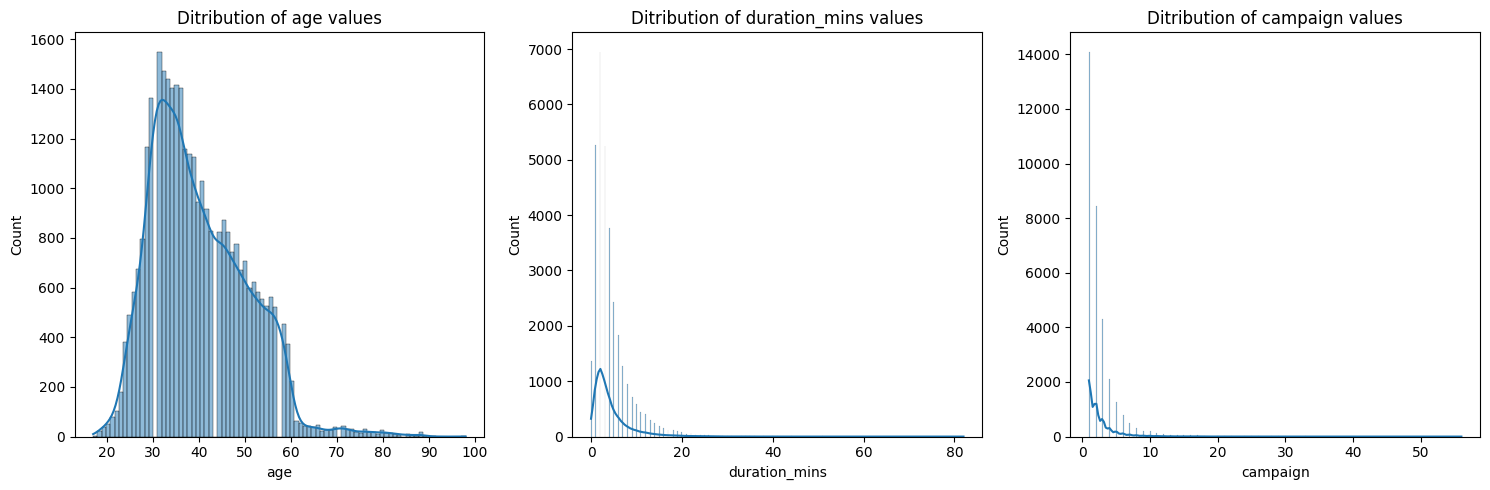

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Call the function
cf.plot_histograms_with_kde(df_new, columns_to_plot=['age', 'duration_mins', 'campaign'])



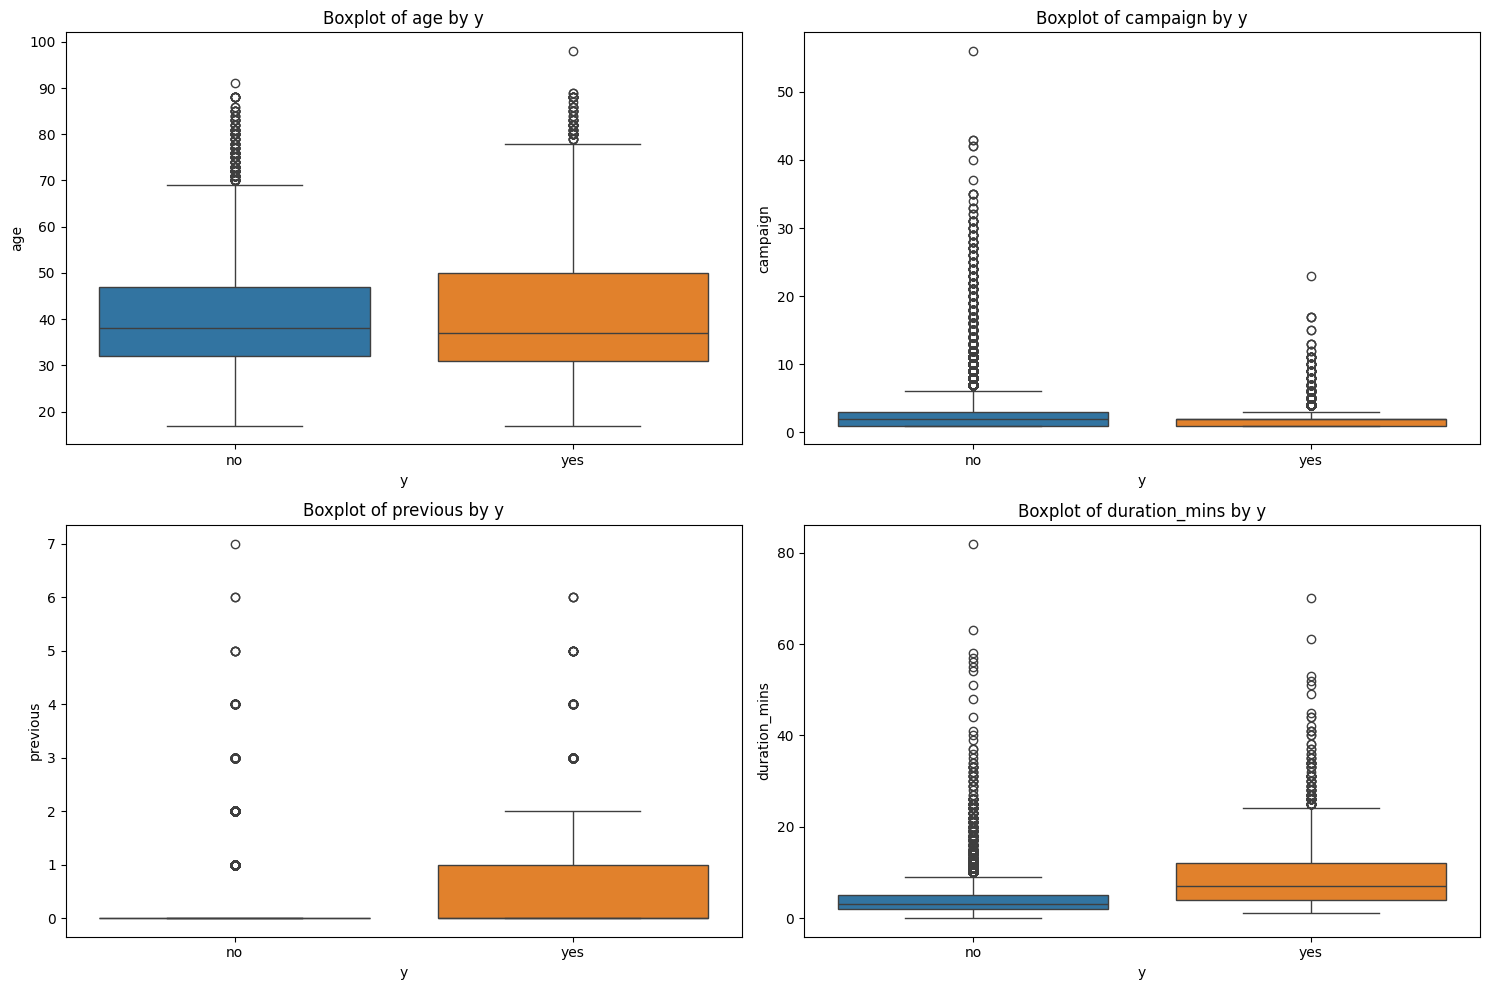

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select numeric columns
numeric_columns = df_new.select_dtypes(include=[np.number]).columns

# Define the number of rows and columns for the subplot grid
ncols = 2
nrows = int(np.ceil(len(numeric_columns) / ncols))

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate over numeric columns and create a boxplot for each one
for idx, col in enumerate(numeric_columns):
    sns.boxplot(data=df_new, x='y', y=col, hue='y', ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {col} by y')

# Remove any unused subplots
for idx in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [13]:
# List of columns to keep
useful_cols = ['age', 'marital',  'education_level', 'job_type', 'income_level', 'housing', 'loan',               
            'contact', 'month', 'day_of_week', 'duration_mins', 'campaign', 'previous', 'poutcome', 'y'
]

c:\Users\user\Projects\Marketing Campaign at Bank\custom_functions.py:186: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cat_corr = pd.concat([df_cat_corr, row], ignore_index=True)


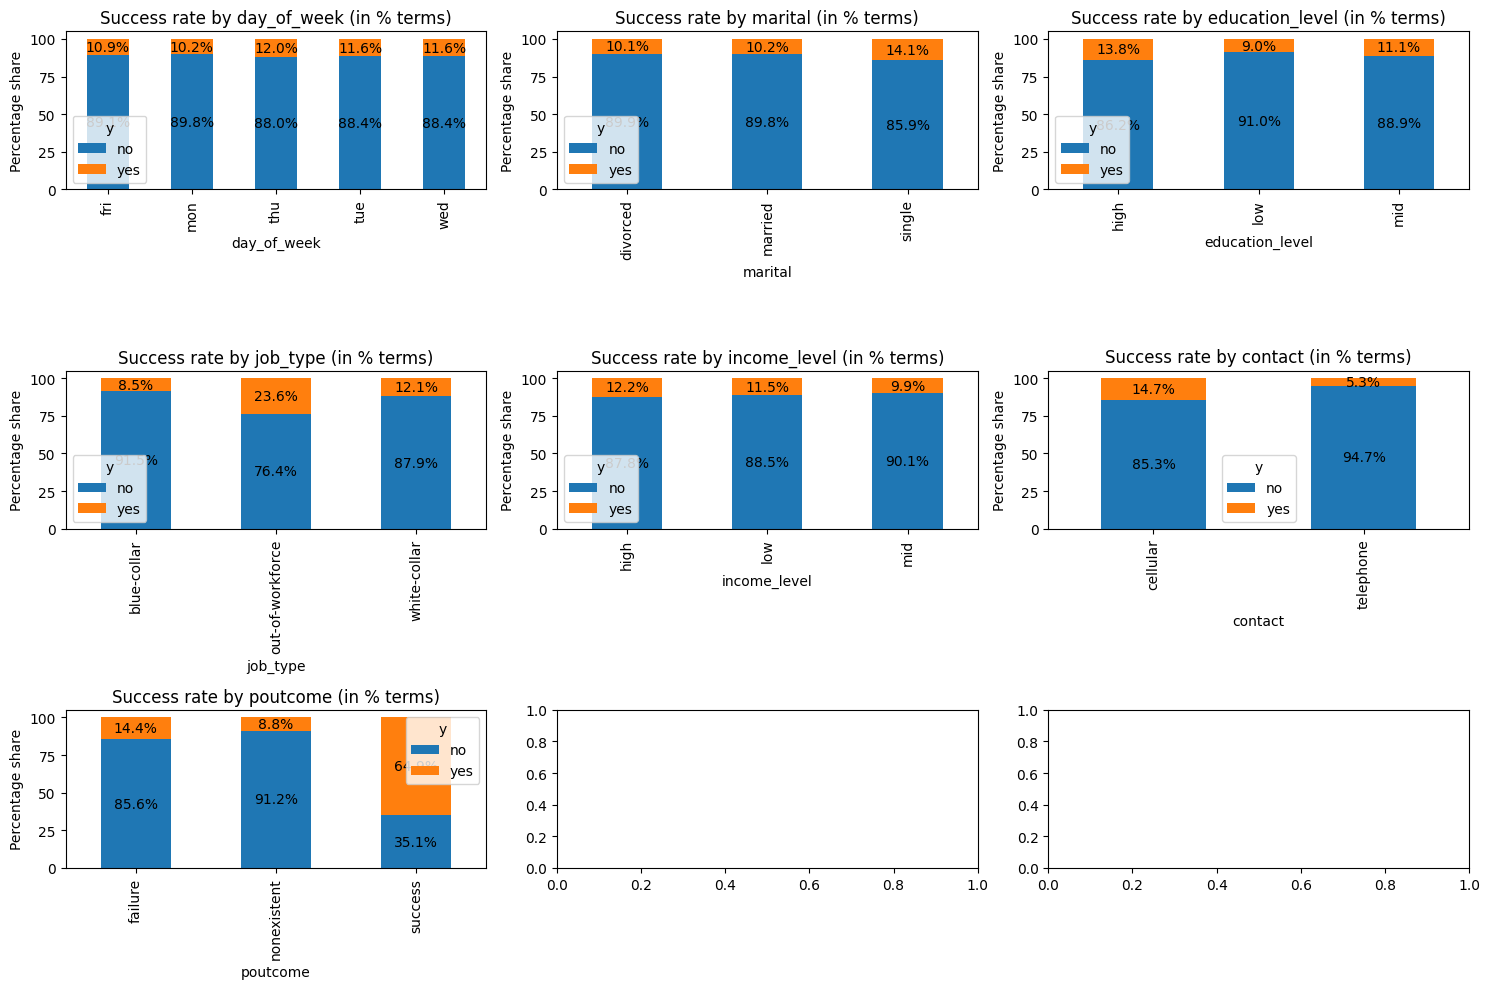

In [14]:
# Calculate the correlation between the target variable and categorical variables
cf.show_categorical_correlation(df_new,
                                target='y', 
                                cols_to_consider=['day_of_week', 'marital', 'education_level', 'job_type', 'income_level','contact', 'poutcome'], 
                                annotate=True,
                                show_details=False)
